# Clustering Exploration

Dataset: https://snap.stanford.edu/data/soc-RedditHyperlinks.html

Political subreddits list: https://github.com/valentinhofmann/politosphere/blob/main/data/subreddits.txt


## Dataset information
- **SOURCE_SUBREDDIT**: the subreddit where the link originates
- **TARGET_SUBREDDIT**: the subreddit where the link ends
- **POST_ID**: the post in the source subreddit that starts the link
- **TIMESTAMP**: time time of the post
- **POST_LABEL**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.
- **POST_PROPERTIES**: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:
1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER

22-86. LIWC Variables

In [129]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [130]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

In [131]:
df_full

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
...,...,...,...,...,...,...
286556,negareddit,debatefascism,68im20s,2017-04-30 16:31:26,1,"441.0,405.0,0.775510204082,0.0294784580499,0.0..."
286557,mildlynomil,justnomil,68imlas,2017-04-30 04:19:03,1,"2226.0,1855.0,0.786163522013,0.00224618149146,..."
286558,mmorpg,blackdesertonline,68ip5os,2017-04-30 16:54:08,1,"1100.0,909.0,0.778181818182,0.00181818181818,0..."
286559,electricskateboards,askreddit,68ipb2s,2017-04-30 16:41:53,1,"1876.0,1567.0,0.78144989339,0.00692963752665,0..."


In [133]:
import re

# Read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|justice|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)
political_subs = list(set(political_subs))

source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only rows where both source and target are political
df = df_full[source_is_political & target_is_political]

In [134]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
360,metaconservative,conservative,1uf4qp,2014-01-04 14:50:38,-1,"769.0,658.0,0.788036410923,0.00130039011704,0...."
362,libertarian,conservative,1uf53xs,2014-01-04 14:41:05,1,"739.0,633.0,0.794316644114,0.00135317997294,0...."
530,libertariancopypasta,politicaldiscussion,1ujbnhs,2014-01-06 12:33:49,1,"1643.0,1383.0,0.793061472915,0.00182592818016,..."
547,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0...."
962,mensrightsmeta,mensrights,1urzs0s,2014-01-15 11:33:58,1,"559.0,471.0,0.75313059034,0.00357781753131,0.0..."
...,...,...,...,...,...,...
285825,enough_sanders_spam,enoughsandersspam,67zs07,2017-04-27 17:34:00,-1,"783.0,681.0,0.757343550447,0.0204342273308,0.0..."
285846,modelussenate,modelsenatefinancecom,68051ns,2017-04-27 18:44:31,1,"109.0,107.0,0.733944954128,0.0642201834862,0.0..."
285866,neoliberal,badeconomics,680xo6s,2017-04-27 21:36:40,1,"1506.0,1309.0,0.750332005312,0.0152722443559,0..."
286055,devotedmap,devoted,685nnas,2017-04-28 17:39:18,1,"1570.0,1508.0,0.269426751592,0.373885350318,0...."


In [135]:
df.to_csv("filtered_network.csv", index=False)

In [136]:
# read in embeddings
df_embeddings = pd.read_csv('data/web-redditEmbeddings-subreddits.csv', header=None)

In [137]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,spiders,0.158972,0.285813,0.226329,-0.183338,-0.163159,-0.188910,0.422705,0.168602,0.178193,...,-0.025041,0.184655,0.111942,-1.125799,0.223129,-0.387323,-0.234882,-0.252297,-0.054315,0.500009
1,askreddit,-0.499114,0.323983,-0.424809,-0.222705,-0.327201,0.412856,1.040088,0.996697,-1.256240,...,0.072151,0.226658,0.535705,0.039861,-0.027087,-0.239952,0.554510,0.676439,-0.328846,0.941547
2,globaloffensivetrade,-0.023145,-1.199374,1.661484,-1.025296,1.424670,-1.179507,-1.035703,0.329301,-0.567272,...,2.998430,-1.235703,-0.326850,4.381238,-1.965378,-2.369674,-0.615389,2.010601,-0.919314,-2.149625
3,fireteams,2.492506,-2.529917,-0.448484,-3.543441,-0.586122,-0.101517,1.837567,-0.215715,-2.460388,...,-1.875214,0.969291,0.497958,2.941132,2.423561,1.315691,-0.959618,0.151845,-0.852492,-0.467526
4,funny,-0.819370,-0.865261,0.301753,0.018787,0.201029,0.070462,0.903895,1.038460,-0.306950,...,1.364194,0.830233,-0.137822,-2.204667,-0.162008,0.390291,-0.556404,0.322684,0.641634,1.320716


In [138]:
# filter embeddings to only political subs
df_pol_embeddings = df_embeddings[df_embeddings[0].isin(political_subs)]

In [139]:
df_pol_embeddings

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
22,politics,-0.246133,1.730181,-0.349746,-2.398734,1.087982,0.313275,1.924499,-0.048492,-0.837829,...,1.773377,0.079027,-0.908972,-0.162458,-0.397316,-0.074321,-0.860635,0.666391,0.908237,0.785750
32,betternews,-0.425452,-1.553768,-0.253225,0.072273,0.060599,0.041088,0.199239,-0.538118,-1.214931,...,0.112669,0.401585,-0.536121,2.001542,-1.340774,0.270228,-0.363143,1.207466,-0.053386,-0.886133
46,politic,-0.093657,-0.408756,-0.416751,-0.745158,-0.405475,-0.476495,1.024330,0.509578,-0.574825,...,-0.185134,0.782819,-0.116337,1.356275,-0.583907,0.659083,-0.115163,1.575137,0.358196,-0.533359
101,sandersforpresident,-1.050458,-0.098431,0.330188,-1.758553,1.364067,-0.613915,2.879395,0.367749,-0.014629,...,0.151883,0.797878,0.231303,-0.183311,-0.246839,-0.072314,-1.254919,-0.140135,0.805701,-0.310626
187,willis7737_news,0.178598,-1.318375,0.293006,-1.060982,0.229292,-0.077264,0.044514,0.051579,-0.564134,...,0.535054,0.201086,-0.515673,1.005197,-0.593210,-0.046060,-0.230489,0.264825,-0.194477,-0.428126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49337,ieforsanders,-0.005637,-0.029763,0.050853,-0.091098,0.033214,-0.023058,0.091035,0.028665,-0.072897,...,0.009305,0.016711,0.014165,0.026484,0.002624,-0.049905,-0.054057,-0.018929,0.042878,0.004230
49434,reformstorm,-0.003097,-0.049987,0.056597,-0.076089,0.015209,-0.045174,0.050449,0.006191,-0.072364,...,0.023774,0.013244,0.005371,0.045988,0.024579,-0.006723,-0.028791,0.028407,0.036764,0.000466
50422,americansocialists,-0.016825,-0.040968,0.055185,-0.064259,0.008062,-0.044411,0.047518,0.027230,-0.070060,...,0.018961,0.009110,-0.008467,0.054599,0.018358,-0.016328,-0.020029,0.013308,0.053042,0.006968
50922,libertarianaustralia,-0.002589,0.026890,-0.027156,0.004635,-0.011114,-0.003656,0.021435,0.016258,0.036980,...,0.006028,0.012897,0.018469,-0.014979,-0.007033,0.002285,-0.000397,-0.009457,0.004263,0.011570


Disclaimer: The embeddings dataset is missing certain subreddits.

In [140]:
df_pol = df_pol_embeddings.set_index([0])

In [141]:
df_pol 

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
politics,-0.246133,1.730181,-0.349746,-2.398734,1.087982,0.313275,1.924499,-0.048492,-0.837829,-0.446861,...,1.773377,0.079027,-0.908972,-0.162458,-0.397316,-0.074321,-0.860635,0.666391,0.908237,0.785750
betternews,-0.425452,-1.553768,-0.253225,0.072273,0.060599,0.041088,0.199239,-0.538118,-1.214931,0.530124,...,0.112669,0.401585,-0.536121,2.001542,-1.340774,0.270228,-0.363143,1.207466,-0.053386,-0.886133
politic,-0.093657,-0.408756,-0.416751,-0.745158,-0.405475,-0.476495,1.024330,0.509578,-0.574825,-0.153666,...,-0.185134,0.782819,-0.116337,1.356275,-0.583907,0.659083,-0.115163,1.575137,0.358196,-0.533359
sandersforpresident,-1.050458,-0.098431,0.330188,-1.758553,1.364067,-0.613915,2.879395,0.367749,-0.014629,-0.386937,...,0.151883,0.797878,0.231303,-0.183311,-0.246839,-0.072314,-1.254919,-0.140135,0.805701,-0.310626
willis7737_news,0.178598,-1.318375,0.293006,-1.060982,0.229292,-0.077264,0.044514,0.051579,-0.564134,-0.101009,...,0.535054,0.201086,-0.515673,1.005197,-0.593210,-0.046060,-0.230489,0.264825,-0.194477,-0.428126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ieforsanders,-0.005637,-0.029763,0.050853,-0.091098,0.033214,-0.023058,0.091035,0.028665,-0.072897,-0.011944,...,0.009305,0.016711,0.014165,0.026484,0.002624,-0.049905,-0.054057,-0.018929,0.042878,0.004230
reformstorm,-0.003097,-0.049987,0.056597,-0.076089,0.015209,-0.045174,0.050449,0.006191,-0.072364,0.003819,...,0.023774,0.013244,0.005371,0.045988,0.024579,-0.006723,-0.028791,0.028407,0.036764,0.000466
americansocialists,-0.016825,-0.040968,0.055185,-0.064259,0.008062,-0.044411,0.047518,0.027230,-0.070060,-0.001357,...,0.018961,0.009110,-0.008467,0.054599,0.018358,-0.016328,-0.020029,0.013308,0.053042,0.006968


In [142]:
from sklearn.manifold import TSNE

NUM_ITER = 3000
perplexities = [10, 20, 30, 40, 50, 60, 75, 100]

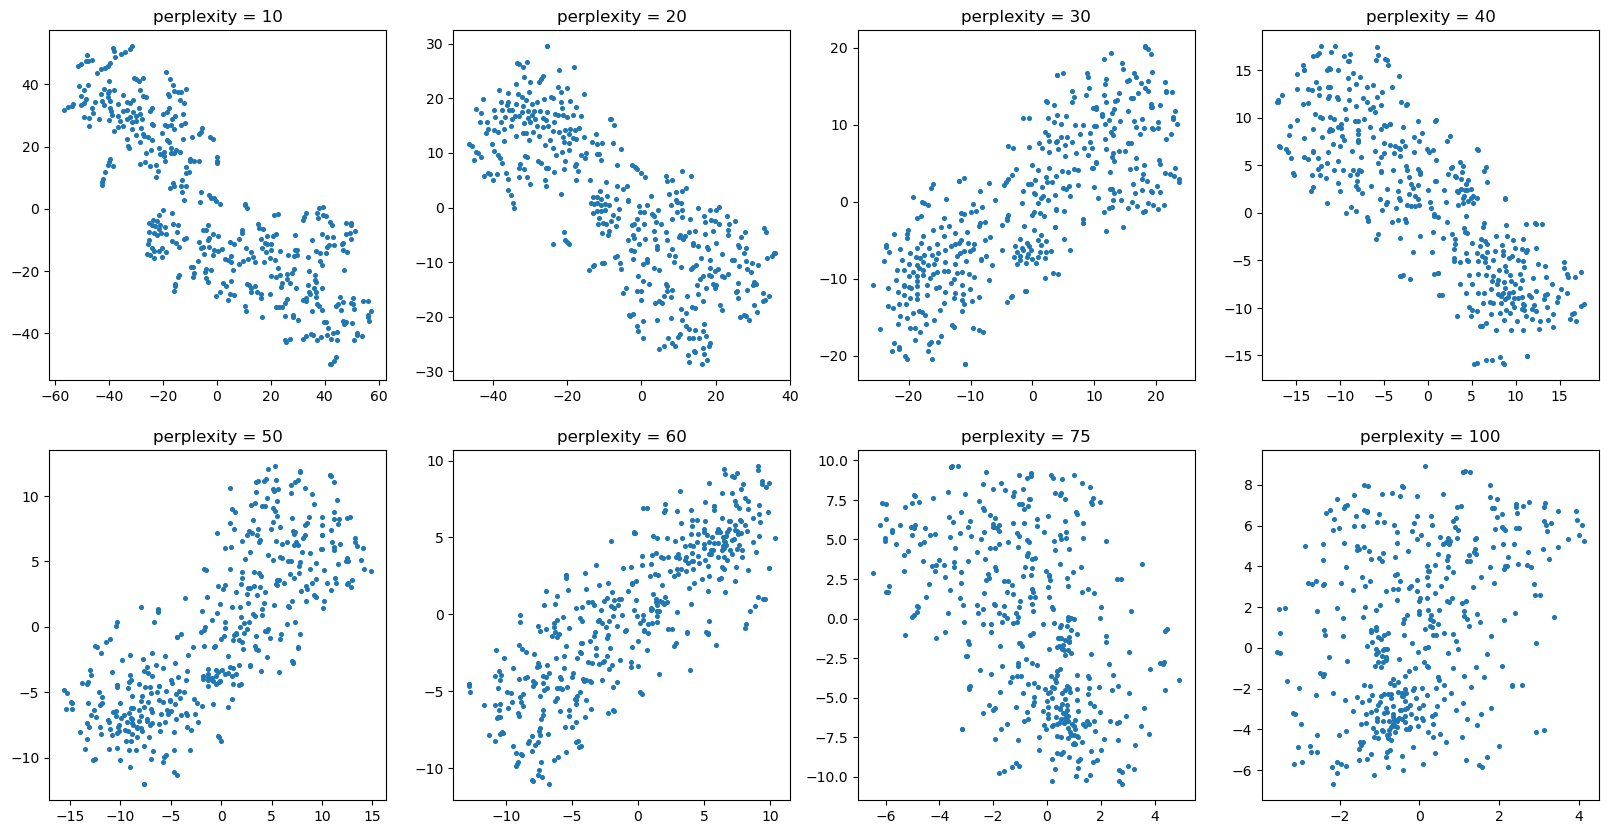

In [143]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
axes = np.ravel(axes)

# plot embeddings with tsne dimensionality reduction 
# using different perplexities
for p, ax in zip(perplexities, axes):
    tsne = TSNE(n_components=2, max_iter=NUM_ITER, perplexity=p, init='random', 
            random_state=1, learning_rate=200)
    reduced_subs = tsne.fit_transform(df_pol)
    ax.scatter(reduced_subs.T[0], reduced_subs.T[1], s=7)
    ax.set_title(f'perplexity = {p}')

Chose perplexity of 50 just based on visual clusters

In [144]:
# choose perplexity 50
tsne = TSNE(n_components=2, max_iter=NUM_ITER, perplexity=50, init='random', 
            random_state=1, learning_rate=200)
reduced_subs = tsne.fit_transform(df_pol)

In [145]:
from sklearn.cluster import KMeans

In [146]:
# kmeans with 18 clusters to compare to louvain
km = KMeans(n_clusters = 18)
km.fit(df_pol)

C:\Users\shiba\micromamba\envs\stat236\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=18)

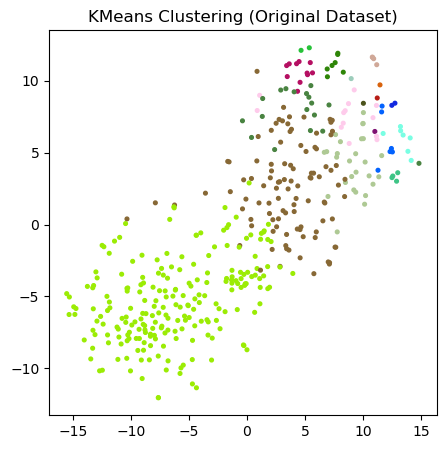

In [158]:
# plot kmeans clusters in tsne embeddings
cluster_colors = np.random.rand(19, 3)

indices_of_nearest_centers = km.labels_

# indexing with an array of indices
colors = cluster_colors[indices_of_nearest_centers] 
plt.figure(figsize = (5, 5))
plt.scatter(reduced_subs.T[0], reduced_subs.T[1], c = colors, s=7)
plt.title('KMeans Clustering (Original Dataset)')
plt.show()

In [148]:
# new dataframe with subreddits and cluster labels
cluster_map = pd.DataFrame()
cluster_map['cluster'] = km.labels_
cluster_map['subreddit'] = df_pol.index.values

In [149]:
cluster_map

,cluster,subreddit
0,12,politics
1,3,betternews
2,15,politic
3,12,sandersforpresident
4,3,willis7737_news
...,...,...
422,1,ieforsanders
423,1,reformstorm
424,1,americansocialists
425,1,libertarianaustralia


In [150]:
cluster_dict = cluster_map.groupby('cluster')['subreddit'].apply(list).to_dict()

In [151]:
for community, nodes in cluster_dict.items():
    print(f"Community {community}: {nodes}")

Community 0: ['enoughtrumpspam', 'hillaryclinton', 'enough_sanders_spam', 'enoughsandersspam']
Community 1: ['injusticemobile', 'devoted', 'injustice', 'justiceserved', 'trumpet', 'botsrights', 'brandonsanderson', 'upvotegifs', 'killthosewhodisagree', 'bidenbro', 'askhillarysupporters', 'dawnofjustice', 'nrxn', 'washingtonforsanders', 'socialjustice101', 'upvoted', 'youngjustice', 'policydebate', 'fivethirtyeight', 'wesanderson', 'kravmaga', 'neoliberal', 'justiceleague', 'antifa', 'gulag', 'monarchism', 'libertarianeurope', 'politicalpartypowers', 'canadapolitic', 'irishpolitics', 'texasforsanders', 'pol', 'race', 'ohioforsanders', 'paforsanders', 'mormonpolitics', 'downvotesmcgoats', 'newengland4sanders', 'daverubin', 'illinois4sanders', 'democratiauniversalis', 'calexit', 'asklibertarians', 'iowaforsanders', 'trump_train', 'codersforsanders', 'tulsi', 'antifacebook', 'trump16', 'michigan4sanders', 'telseccompolicy', 'nevadaforsanders', 'colorado4sanders', 'republicansforsanders', 'a

In [152]:
# kmeans with 18 clusters fit to tsne embeddings
km_tsne = KMeans(n_clusters = 19)
km_tsne.fit(reduced_subs)

C:\Users\shiba\micromamba\envs\stat236\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=19)

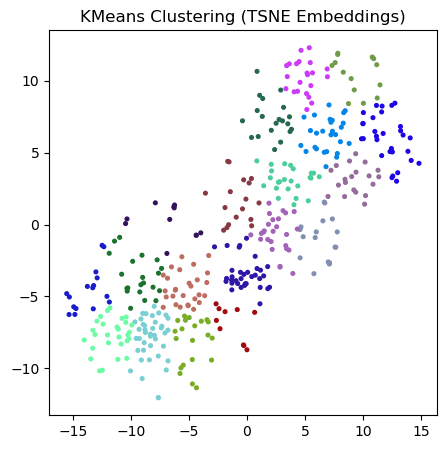

In [159]:
# plot kmeans clusters in tsne embeddings
cluster_colors = np.random.rand(19, 3)

indices_of_nearest_centers = km_tsne.labels_

# indexing with an array of indices
colors = cluster_colors[indices_of_nearest_centers] 
plt.figure(figsize = (5, 5))
plt.scatter(reduced_subs.T[0], reduced_subs.T[1], c = colors, s=7)
plt.title('KMeans Clustering (TSNE Embeddings)')
plt.show()

In [153]:
# new dataframe with subreddits and cluster labels
tsne_clusters = pd.DataFrame()
tsne_clusters['cluster'] = km_tsne.labels_
tsne_clusters['subreddit'] = df_pol.index.values

In [154]:
tsne_dict = tsne_clusters.groupby('cluster')['subreddit'].apply(list).to_dict()

In [155]:
for community, nodes in tsne_dict.items():
    print(f"Community {community}: {nodes}")

Community 0: ['injusticemobile', 'injustice', 'trumpet', 'botsrights', 'brandonsanderson', 'killthosewhodisagree', 'dawnofjustice', 'socialjustice101', 'youngjustice', 'policydebate', 'wesanderson', 'kravmaga', 'justiceleague', 'fifthworldpolitics', 'feelsofjustice', 'explainmydownvotes']
Community 1: ['australianpolitics', 'postnationalist', 'governmentoppression', 'libertarianmeme', 'qualitynews', 'cyberlaws', 'badgovnofreedom', 'antiwar', 'israelexposed', 'restorethefourth', 'media_criticism', 'stillsandersforpres', '2016_elections', 'humanrights', 'internationalpolitics', 'austrian_economics', 'censorship', 'chomsky', 'obamacare', 'moderatepolitics', 'libertarianpartyusa', 'propaganda', 'anarchy', 'conspiracyfact', 'ronpaul', 'berniesanderssucks', 'liberalgunowners']
Community 2: ['devoted', 'fivethirtyeight', 'politicalpartypowers', 'canadapolitic', 'democratiauniversalis', 'telseccompolicy', 'georgism', 'progressivegrowth', 'devotedmap', 'socialistamerica', 'downvotegifs', 'toast